Ce fichier est à executer en entier afin de tester un modèle sur l'environnement.

Pour entrainer un modèle sur cet environnement, il faut exécuter main2.py

In [1]:
import numpy as np
from gym import Wrapper



class CustomRewardWrapper(Wrapper):
    def __init__(self, env, config):
        super().__init__(env)
        self.config = config

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)
        base_env = self.env.unwrapped
        vehicle = base_env.vehicle

        reward = 0.0

        # Pénalité collision
        if vehicle.crashed:
            reward += self.config.get("collision_reward")

        # Valeur qui récompense être sur la route et pénalise être hors route
        reward += self.config.get("on_road_reward") * vehicle.on_road
        
        # # Valeur qui pénalise être hors route
        # reward += self.config.get("off_road_reward") * (1 - vehicle.on_road)

        # Pénalité d'action (encourage les petites actions)
        reward += self.config.get("action_reward") * np.square(action).sum()

        # # # ➕ Pénalité de distance au centre de la voie
        # if vehicle.lane is not None:
        #     lane_center_offset = abs(vehicle.lane.distance(vehicle.position))
        #     reward += self.config.get("lane_centering_reward", 0.2) * (1 - lane_center_offset)

        # Récompense pour éviter les collisions (bonus à la fin de l'épisode)
        if terminated or truncated:
            if not vehicle.crashed:
                reward += self.config.get("no_collision_reward", 10)

        return obs, reward, terminated, truncated, info



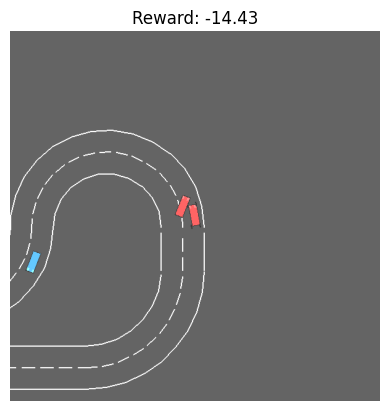

Reward total de l'épisode : -14.429431075273897


In [2]:
import torch
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Net2 import NetContinousActions
from copy import deepcopy
from configuration2 import config_dict

# Création de l'environnement
env = gym.make('racetrack-v0', render_mode="rgb_array")
env.unwrapped.configure(config_dict)
# On Wrappe l'environnement pour redéfinir la récompense	
env = CustomRewardWrapper(env, config_dict)
env.reset()

obs_dim = int(np.prod(env.observation_space.shape))
act_dim = env.action_space.shape[0]

# Charger le modèle acteur
# Créez un modèle avec la taille d'observation correspondant au modèle sauvegardé
obs_dim = 98  # Taille utilisée lors de l'entraînement, pas la taille actuelle
act_dim = env.action_space.shape[0]
actor = NetContinousActions(obs_dim, 128, act_dim)
# actor.load_state_dict(torch.load("ppo_actor_continuous.pth"))
actor.load_state_dict(torch.load("ppo_actor_continuous.pth", map_location=torch.device('cpu')))
actor.eval()

# Exécution d'un épisode avec affichage
def run_one_episode_ppo(env, actor, display=True):
    env_eval = deepcopy(env)
    obs, _ = env_eval.reset()
    done = False
    total_reward = 0

    print(len(env_eval.unwrapped.road.vehicles))
    while not done:
        obs_flat = np.array(obs, dtype=np.float32).flatten()
        state_tensor = torch.tensor(obs_flat).unsqueeze(0)

        with torch.no_grad():
            mean, _ = actor(state_tensor)
            action = mean.numpy()[0]  # action deterministe : pas d'échantillonnage

        obs, reward, terminated, truncated, _ = env_eval.step(np.array([action]))
        done = terminated or truncated
        total_reward += reward

        if display:
            clear_output(wait=True)
            img = env_eval.render()
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Reward: {total_reward:.2f}")
            plt.show()

    print(f"Reward total de l'épisode : {total_reward}")
    env_eval.close()

# Lancer une visualisation de l'agent PPO entraîné
run_one_episode_ppo(env, actor, display=True)


In [6]:
state, _ = env.reset()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


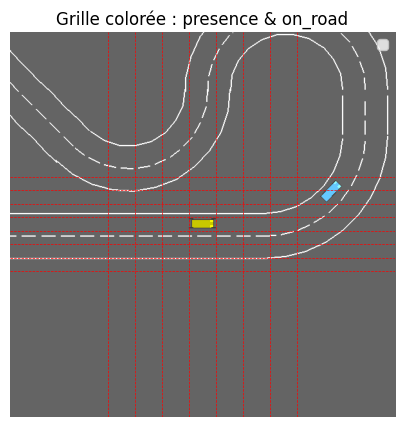

Agent's Observation (State):
Shape: (2, 7, 7) (channels, height, width)
Presence Layer:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
On Road Layer:
[[1. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0.]]


: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenir la perception de l'agent sans prendre d'action
state, reward, terminated, truncated, _ = env.step(np.zeros(act_dim))


# Rendu de l'image
frame = env.render()

# Récupération des paramètres d'observation
obs_config = env.unwrapped.config["observation"]
x_min, x_max = obs_config["grid_size"][0]
y_min, y_max = obs_config["grid_size"][1]
x_step, y_step = obs_config["grid_step"]

grid_x = np.arange(x_min, x_max + 0.1, x_step)
grid_y = np.arange(y_min, y_max + 0.1, y_step)

# Paramètres pour conversion vers les coordonnées d'écran
scaling = env.unwrapped.config["scaling"]
screen_width = env.unwrapped.config["screen_width"]
screen_height = env.unwrapped.config["screen_height"]
center_x = screen_width * env.unwrapped.config["centering_position"][0]
center_y = screen_height * env.unwrapped.config["centering_position"][1]


### --- Affichage 2 : Grid --- ###
plt.figure(figsize=(10, 5))
plt.imshow(frame)



# Ajout des lignes de grille
for gx in grid_x:
    plt.axvline(center_x + gx * scaling, color='red', linestyle='--', linewidth=0.5)
for gy in grid_y:
    plt.axhline(center_y - gy * scaling, color='red', linestyle='--', linewidth=0.5)

plt.title("Grille colorée : presence & on_road")
plt.axis('off')
plt.legend(loc='upper right')
plt.show()

### --- Affichage console --- ###
print("Agent's Observation (State):")
print(f"Shape: {state.shape} (channels, height, width)")
print("Presence Layer:")
print(state[0])
print("On Road Layer:")
print(state[1])
